In [1]:
import json

import numpy as np
import pandas as pd
import pymongo
import scipy
from bson import ObjectId, json_util
from pandas.io.json import json_normalize
from pymongo import MongoClient as Connection
from scipy import sparse, spatial
from scipy.spatial.distance import cdist, pdist, squareform
from sklearn.metrics.pairwise import cosine_similarity

# scientific notation disabled form smaller numbers
pd.options.display.float_format = '{:.5f}'.format

# alles resultate anzeigen und nicht nur das letzte
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"



In [2]:
# display multiple outputs in one row
import pandas as pd
import numpy as np
from IPython.display import display, HTML

CSS = """
.output {
    flex-direction: row;
}
"""

HTML('<style>{}</style>'.format(CSS))

In [3]:
connection = Connection()
db = connection.recipe_db
input_data = db.recipes_test_copy

data = json.loads(json_util.dumps(input_data.find()))

In [4]:
ing = pd.DataFrame(json_normalize(data, record_path='ingredients',
                             meta='id', record_prefix='ingredients_', errors='ignore'))


nutritions = pd.DataFrame(json_normalize(data, record_path='nutritions',
                            meta=['id', 'prep_time', 'rating', 'rating_count', 'ready_in_time', 'review_count']))


In [5]:
#ingredients
#ingredients.loc[ingredients['id'] == 9380]

In [6]:
#ingredients.loc[ingredients['ingredients_id'] == 2972]

In [7]:
#  ------  erstellung und data cleansing - Ingredients

# schmeiss alle zutaten raus, die weniger als 5 mal verwendet werden
# setze multiinde auf 'id' und 'ingredients_id'
ingredients = ing.set_index(['id', 'ingredients_id'])

# filtere alle Zutaten samt ihrer rezepte id, die weniger gleich 5 mal vorkommen
ingredients_eqles_5_ing = ingredients.groupby(
    'ingredients_id').filter(lambda x: len(x) <= 5)

# droppe alle rezepte, die eine Zutate besitzen, die weniger gleich 5 Mal vorkommen
ingredients_filt = ingredients.drop(ingredients_eqles_5_ing.index.get_level_values('id').values, level=0)

# drop alls rows with ingredients_id == 0
ingredients_eqal_zero = ingredients_filt[ingredients_filt.index.get_level_values('ingredients_id') == 0]
ingredients_filt = ingredients_filt.drop(ingredients_eqal_zero.index.get_level_values('id').values, level=0)


In [57]:
nutritions

name    amount  unit display_value percent_daily_value  \
0                     Fat  35.95846     g            36                  55   
1                Calories 509.80290  kcal           510                  25   
2             Cholesterol  95.27404    mg            95                  32   
3                  Sodium 353.60110    mg           354                  14   
4           Carbohydrates  32.26605     g          32.3                  10   
...                   ...       ...   ...           ...                 ...   
126075             Sugars   0.32176     g           0.3                   0   
126076          Potassium 392.87760    mg           393                  11   
126077      Saturated Fat   4.65290     g           4.7                  23   
126078  Calories from Fat 168.17000  kcal           168                   -   
126079      Dietary Fiber   2.09705     g           2.1                   8   

            id prep_time  rating rating_count ready_in_time review_count  
0        59661        20 4.33559         1180            40          817  
1        59661        20 4.33559         1180            40          817  
2        59661        20 4.33559         1180            40          817  
3        59661        20 4.33559         1180            40          817  
4        59661        20 4.33559         1180            40          817  
...        ...       ...     ...          ...           ...          ...  
126075  244188        10 4.80556           36          1095           30  
126076  244188        10 4.80556           36          1095           30  
126077  244188        10 4.80556           36          1095           30  
126078  244188        10 4.80556           36          1095           30  
126079  244188        10 4.80556           36          1095           30  

[126080 rows x 11 columns]

In [58]:
ingredients_filt

ingredients_name  \
id     ingredients_id                                                      
59661  16157                                                 10 g butter   
       4405                                     40 g sliced green onions   
       4342                                  1-1/2 cloves garlic, minced   
       4520            3/4 (10 ounce) package frozen chopped spinach ...   
       16243                                        180 g ricotta cheese   
...                                                                  ...   
229659 16423                           1-3/4 sprigs fresh thyme, divided   
       20270                          3/8 white onion, chopped - divided   
       16157                               40 g butter, sliced into pats   
       4292                             80 g chopped fresh celery leaves   
       3474            1/8 (750 milliliter) bottle white wine, or mor...   

                       ingredients_grams ingredients_type  
id     ingredients_id                                      
59661  16157                    11.36000           Normal  
       4405                     41.80000           Normal  
       4342                      4.80000           Normal  
       4520                    227.20000           Normal  
       16243                   182.40001           Normal  
...                                  ...              ...  
229659 16423                     0.66667           Normal  
       20270                    36.66667           Normal  
       16157                    37.83334           Normal  
       4292                     80.00000           Normal  
       3474                    124.69144           Normal  

[36827 rows x 3 columns]

In [59]:
ingredients_filt.index.get_level_values('id').values

array([ 59661,  59661,  59661, ..., 229659, 229659, 229659])

In [8]:
#  ------ Erstellung und cleansing des Nutrition Dataframes

# erstelle neue liste auf basis der bereits gefilterten rezepte aus ingredients_filt
id_overlap_mask = nutritions['id'].isin(ingredients_filt.index.get_level_values('id').values)

# erstelle datenframe auf basis der overlapliste
nutritions_filt = nutritions.loc[id_overlap_mask]

nutrition_db = nutritions_filt.pivot_table(
    index=['id'],
    columns=['name'],
    values=['amount'],
).reset_index()

nutrition_db.set_index('id', inplace=True)

# remove multiindex 'amount'
nutrition_db.columns = nutrition_db.columns.droplevel(0)

# entferne alle NA
nutrition_db = nutrition_db.dropna()

# gleiche nochmals die ids der beiden dataframe nutrition und ingredients ab, da der nutrition dataframe noch NA Werte hatt
id_overlap_mask = ingredients_filt.index.get_level_values('id').isin(nutrition_db.index)
ingredients_db = ingredients_filt[id_overlap_mask]

# abgleich ob anzahl der indizes von nutrition und zutaten dataframe gleich sind
nutrition_db.index.nunique()
ingredients_db.index.get_level_values('id').nunique()
nutrition_db

4061

4061

name     Calcium  Calories  Calories from Fat  Carbohydrates  Cholesterol  \
id                                                                          
6900   117.79860 105.27020           21.33330       17.98829      1.62667   
7198   244.16520 731.50920          325.65230       73.29574     88.69389   
8493   415.52450 454.28300          177.75310       23.83120    203.86850   
8494    58.08641 834.44480          514.68470        4.76954    283.75000   
8495   379.01410 418.75340          174.23740       12.62089    123.58900   
...          ...       ...                ...            ...          ...   
258878   9.30933 189.09670          106.42770        0.12118     70.99000   
259870 116.87750 533.78500          254.83060       65.83649      0.00000   
260193  37.24250 300.08690           43.28884       13.86486    118.04670   
261124  36.90501 287.12290          135.42690        3.59909     96.13005   
263813 485.16930 613.20350          221.93320       47.63988    101.46880   

name    Dietary Fiber      Fat    Folate    Iron  Magnesium  \
id                                                            
6900          0.56557  2.37037  39.16360 1.14346    7.30480   
7198          4.64147 36.18359 249.14210 5.76566   52.89296   
8493          1.99500 19.75034  63.05025 3.11258   54.35775   
8494          0.63600 57.18719  33.44816 3.72336   84.44925   
8495          0.75239 19.35971  25.41156 1.89411   60.48306   
...               ...      ...       ...     ...        ...   
258878        0.01650 11.82530   5.34667 1.02767   16.89067   
259870       12.46288 28.31451 179.44000 4.86495  140.72750   
260193        1.03600  4.80987   7.15000 1.63545   46.19250   
261124        0.67217 15.04743  18.83792 2.01199   33.50583   
263813        1.98784 24.65924 123.37230 3.80631   79.57173   

name    Niacin Equivalents  Potassium  Protein  Saturated Fat     Sodium  \
id                                                                         
6900               1.82102   54.07343  2.84282        0.59495  385.75980   
7198              13.51325  509.34610 27.58195       11.50691 1660.20300   
8493              23.43780  509.41500 44.07647        9.96063 1107.91100   
8494              39.18463  807.96980 71.10712       16.35430  567.97140   
8495              24.62857  457.03550 46.06678       10.03598  931.58340   
...                    ...        ...      ...            ...        ...   
258878             8.44069  171.30030 19.15713        3.30546   90.00200   
259870             7.50368 2441.57700 11.27299        4.00073  141.41000   
260193            21.66052  476.54750 45.85212        1.41095 1545.54100   
261124            16.46910  372.90480 32.54562        3.21560  293.74010   
263813            25.88058  586.18620 49.29259       14.67424  497.95620   

name     Sugars  Thiamin  Vitamin A - IU  Vitamin B6  Vitamin C  
id                                                               
6900    1.72141  0.17169       116.75390     0.01709    0.04505  
7198    2.83424  0.89150       699.95980     0.36319   67.32533  
8493    3.45304  0.17406       578.21420     0.64563    1.91250  
8494    2.08741  0.02921       619.52510     1.37244   20.17546  
8495    1.42275  0.29605       406.88370     0.82640   11.72893  
...         ...      ...             ...         ...        ...  
258878  0.04050  0.05192       125.95000     0.24153    0.03000  
259870 16.18104  0.55845      2659.15000     1.63708  135.49670  
260193  4.58523  0.08974       217.95000     0.61491    1.23025  
261124  1.22104  0.09603       527.56960     0.57170    9.79475  
263813  7.97937  0.17697       893.24020     0.51950    2.10568  

[4061 rows x 20 columns]

In [13]:
id_list = [215014, 8669, 16700, 16354, 12720, 8652, 8887, 51283, 45954, 213742, 14595,
           219164, 16348, 143082, 8665, 11758, 223042, 236609, 8778, 65896, 24264, 11679, 141678, 9023]

ingredients_db.reset_index(inplace=True)

recipe_db = pd.get_dummies(ingredients_db['ingredients_id']).groupby(
    ingredients_db['id']).apply(max)



In [22]:
new_ingredients = ingredients_db.copy()
#new_ingredients = new_ingredients.groupby("id")["ingredients_grams"].sum().reset_index()

In [23]:
new_ingredients

id  ingredients_id  \
0       59661           16157   
1       59661            4405   
2       59661            4342   
3       59661            4520   
4       59661           16243   
...       ...             ...   
36685  229659           16423   
36686  229659           20270   
36687  229659           16157   
36688  229659            4292   
36689  229659            3474   

                                        ingredients_name  ingredients_grams  \
0                                            10 g butter           11.36000   
1                               40 g sliced green onions           41.80000   
2                            1-1/2 cloves garlic, minced            4.80000   
3      3/4 (10 ounce) package frozen chopped spinach ...          227.20000   
4                                   180 g ricotta cheese          182.40001   
...                                                  ...                ...   
36685                  1-3/4 sprigs fresh thyme, divided            0.66667   
36686                 3/8 white onion, chopped - divided           36.66667   
36687                      40 g butter, sliced into pats           37.83334   
36688                   80 g chopped fresh celery leaves           80.00000   
36689  1/8 (750 milliliter) bottle white wine, or mor...          124.69144   

      ingredients_type  
0               Normal  
1               Normal  
2               Normal  
3               Normal  
4               Normal  
...                ...  
36685           Normal  
36686           Normal  
36687           Normal  
36688           Normal  
36689           Normal  

[36690 rows x 5 columns]

In [24]:
new_ingredients.sort_values(by='ingredients_grams')

id  ingredients_id                   ingredients_name  \
2294    26609           16406    freshly ground pepper, to taste   
4270    43742           16406              black pepper to taste   
27915   23550           16421           salt and pepper to taste   
35623   11983           16421           salt and pepper to taste   
24543   14551           16406       ground black pepper to taste   
...       ...             ...                                ...   
26395   30501            5446  4 (1 1/2 pound) Cornish game hens   
34561  229874            5446                4 Cornish game hens   
25680   16704            4442                        15 potatoes   
30105  232865            2496                          3 l water   
36045  221900            3138         7.3 kg corned beef brisket   

       ingredients_grams ingredients_type  
2294             0.00000      HideAmounts  
4270             0.00000      HideAmounts  
27915            0.00000      HideAmounts  
35623            0.00000      HideAmounts  
24543            0.00000      HideAmounts  
...                  ...              ...  
26395         2692.00000           Normal  
34561         2692.00000           Normal  
25680         3195.00000           Normal  
30105         3784.96000           Normal  
36045         7257.60000           Normal  

[36690 rows x 5 columns]

In [32]:
gramms_ingredients = new_ingredients.groupby("id")["ingredients_grams"].sum().reset_index().copy()

In [34]:
gramms_ingredients.sort_values(by='ingredients_grams')

id  ingredients_grams
1214   20881           21.22222
2493   79255           73.29343
2831  106030           79.13929
1788   34531           91.28767
410    12063          107.10890
...      ...                ...
2137   55946         4711.39585
3734  229874         4731.00000
2063   51849         4780.40889
3838  232865         5779.31317
3568  221900         7908.48667

[4061 rows x 2 columns]

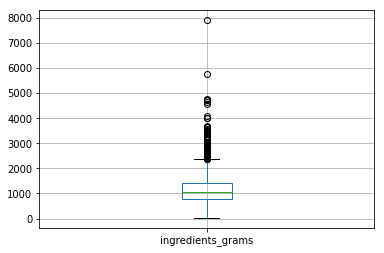

In [52]:
gramms_ingredients.boxplot(['ingredients_grams'])

In [44]:
Q1 = gramms_ingredients.quantile(0.25)
Q3 = gramms_ingredients.quantile(0.75)
IQR = Q3 - Q1

df = gramms_ingredients[~((gramms_ingredients < (Q1 - 1.5 * IQR)) |(gramms_ingredients > (Q3 + 1.5 * IQR))).any(axis=1)].copy()

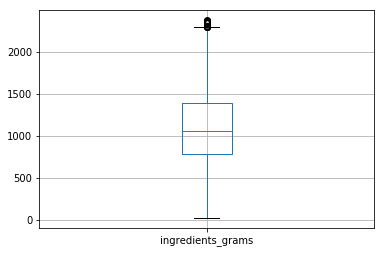

In [48]:
df.boxplot(['ingredients_grams'])

In [53]:
df_start_at_fivehundret = df[df['ingredients_grams'].between(500, 2373.58225, inclusive=False)].copy()

In [55]:
df_start_at_fivehundret.sort_values(by='ingredients_grams')

id  ingredients_grams
549    14511          500.78858
3359  214759          501.52500
2516   80827          502.37646
1045   18377          502.93333
2196   60704          503.60000
...      ...                ...
2524   80992         2353.17500
140     8772         2364.46678
3650  228045         2364.60208
1926   44033         2365.12018
3042  151997         2366.98766

[3769 rows x 2 columns]

In [61]:
df_start_at_fivehundret.set_index('id', inplace=True)

In [62]:
df_start_at_fivehundret.index.get_level_values('id').values

array([  7198,   8493,   8494, ..., 260193, 261124, 263813])

In [63]:
id_overlap_mask = nutritions['id'].isin(df_start_at_fivehundret.index.get_level_values('id').values)


In [70]:

# erstelle datenframe auf basis der overlapliste
nutritions_filt_gramm = nutritions.loc[id_overlap_mask]

nutrition_db2 = nutritions_filt_gramm.pivot_table(
    index=['id'],
    columns=['name'],
    values=['amount'],
).reset_index()

nutrition_db2.set_index('id', inplace=True)
nutrition_db2.columns = nutrition_db2.columns.droplevel(0)

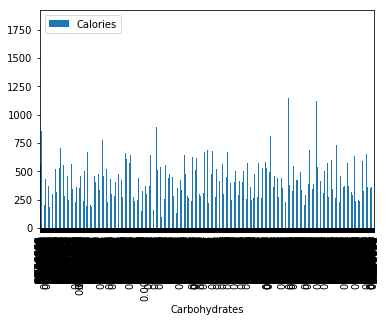

In [81]:
import matplotlib.pyplot as plt
import pandas as pd

# gca stands for 'get current axi
s'
ax = plt.gca()

nutrition_db2.plot(kind='bar',x='Carbohydrates',y='Calories',ax=ax)
#df.plot(kind='line',x='name',y='num_pets', color='red', ax=ax)

plt.show()

In [82]:
# Seaborn visualization library
import seaborn as sns
# Create the default pairplot
sns.pairplot(nutrition_db2)

In [73]:
nutrition_db.describe()

name     Calcium   Calories  Calories from Fat  Carbohydrates  Cholesterol  \
count 4061.00000 4061.00000         4061.00000     4061.00000   4061.00000   
mean   146.27411  436.40975          205.37237       29.33344     96.51821   
std    159.44644  208.88694          142.06851       23.54763     64.77935   
min      0.93181   13.63194            0.92750        0.00000      0.00000   
25%     41.70671  293.53170          110.96110       10.17949     58.52000   
50%     82.98421  402.21690          179.09050       24.76230     83.20487   
75%    191.93500  543.94100          270.12480       43.31408    126.13500   
max   1264.32600 4709.19900         3455.29000      236.72050    979.77610   

name   Dietary Fiber        Fat     Folate       Iron  Magnesium  \
count     4061.00000 4061.00000 4061.00000 4061.00000 4061.00000   
mean         2.63126   22.81915   60.77660    3.17214   51.61693   
std          2.63839   15.78539   60.62238    2.60958   32.33175   
min          0.00000    0.10306    0.00000    0.07193    0.85861   
25%          0.72400   12.32901   15.83472    1.76227   31.96074   
50%          1.90878   19.89894   39.23425    2.72961   45.60215   
75%          3.67149   30.01386   88.15191    3.95205   63.72025   
max         27.83175  383.92110  519.53590   55.89075  590.39220   

name   Niacin Equivalents  Potassium    Protein  Saturated Fat      Sodium  \
count          4061.00000 4061.00000 4061.00000     4061.00000  4061.00000   
mean             12.29695  537.39301   27.76348        8.69244   846.57719   
std               7.29271  325.05535   13.36397        7.23535   736.50210   
min               0.03511    4.66014    0.44604        0.01992     2.67762   
25%               7.13499  330.88660   19.10435        3.46839   403.24870   
50%              10.96189  474.42300   26.44455        6.94486   719.30310   
75%              16.48777  660.33650   34.30157       11.96910  1084.22600   
max             109.01730 6063.16200  273.21630      103.43580 22099.37000   

name      Sugars    Thiamin  Vitamin A - IU  Vitamin B6  Vitamin C  
count 4061.00000 4061.00000      4061.00000  4061.00000 4061.00000  
mean     6.72518    0.30159      1221.36958     0.50872   16.72761  
std      9.17572    0.30494      2557.63597     0.34450   26.92523  
min      0.00000    0.00012         0.00000     0.00252    0.00000  
25%      1.70200    0.10256       226.24930     0.26951    2.03857  
50%      3.83038    0.19551       569.17940     0.43700    6.49813  
75%      7.81290    0.39492      1118.82800     0.68543   19.57264  
max    136.50510    3.25879     40386.87000     5.98334  507.27710

In [71]:
nutrition_db2.describe()

name     Calcium   Calories  Calories from Fat  Carbohydrates  Cholesterol  \
count 3769.00000 3769.00000         3769.00000     3769.00000   3769.00000   
mean   147.65186  437.44356          206.11989       29.13837     97.10705   
std    160.00437  183.08939          125.84039       22.82783     60.47445   
min      2.24700   51.34326            1.32300        0.00000      0.00000   
25%     41.91497  302.97180          116.53740       10.22622     60.37200   
50%     83.16850  407.24760          182.76280       24.77198     85.12875   
75%    193.60330  541.55730          271.88850       43.25740    126.73700   
max   1264.32600 1828.19200          989.10300      236.72050    708.85000   

name   Dietary Fiber        Fat     Folate       Iron  Magnesium  \
count     3769.00000 3769.00000 3769.00000 3769.00000 3769.00000   
mean         2.59745   22.90221   60.52532    3.15292   51.41953   
std          2.51004   13.98227   59.87693    2.44362   29.11251   
min          0.00000    0.14700    0.00000    0.19784    0.99745   
25%          0.74534   12.94860   15.88967    1.81434   33.22178   
50%          1.94552   20.30698   38.70226    2.76635   45.93000   
75%          3.66472   30.20983   88.10015    3.93263   63.26534   
max         27.83175  109.90030  519.53590   55.89075  590.39220   

name   Niacin Equivalents  Potassium    Protein  Saturated Fat     Sodium  \
count          3769.00000 3769.00000 3769.00000     3769.00000 3769.00000   
mean             12.44388  532.06962   28.05446        8.74674  851.15449   
std               6.89390  267.49221   12.01243        6.80052  643.62150   
min               0.03511   21.35641    0.75050        0.01992    5.20206   
25%               7.40249  345.47480   19.97439        3.62848  418.62460   
50%              11.16012  480.78320   26.86635        7.16552  734.00700   
75%              16.56103  654.28050   34.32086       12.13782 1093.02700   
max              47.57578 1931.48800   99.72639       59.31002 7322.28900   

name      Sugars    Thiamin  Vitamin A - IU  Vitamin B6  Vitamin C  
count 3769.00000 3769.00000      3769.00000  3769.00000 3769.00000  
mean     6.72550    0.30428      1169.01319     0.50992   16.28996  
std      8.81425    0.30165      2322.11124     0.31208   24.36018  
min      0.00000    0.00055         0.00000     0.00497    0.00000  
25%      1.76465    0.10514       236.89130     0.28450    2.15387  
50%      3.90585    0.19772       581.41080     0.44630    6.66049  
75%      7.83809    0.39695      1113.57900     0.68318   19.57264  
max    104.81810    2.35457     38664.70000     3.83736  270.41310

/usr/local/lib/python3.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x124a76890>,
      dtype=object)

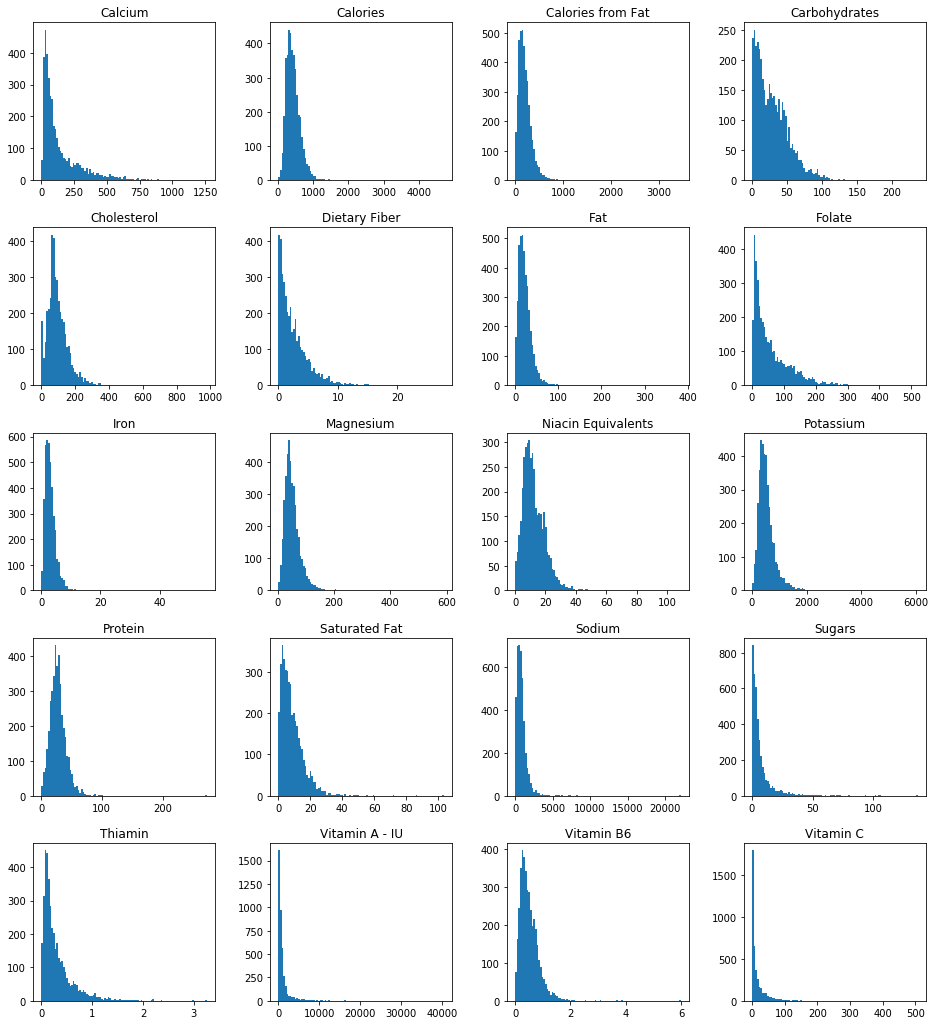

In [69]:
nutrition_db.hist(bins= 100, grid= 'false', figsize = (16,18))

/usr/local/lib/python3.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12dde1450>,
      dtype=object)

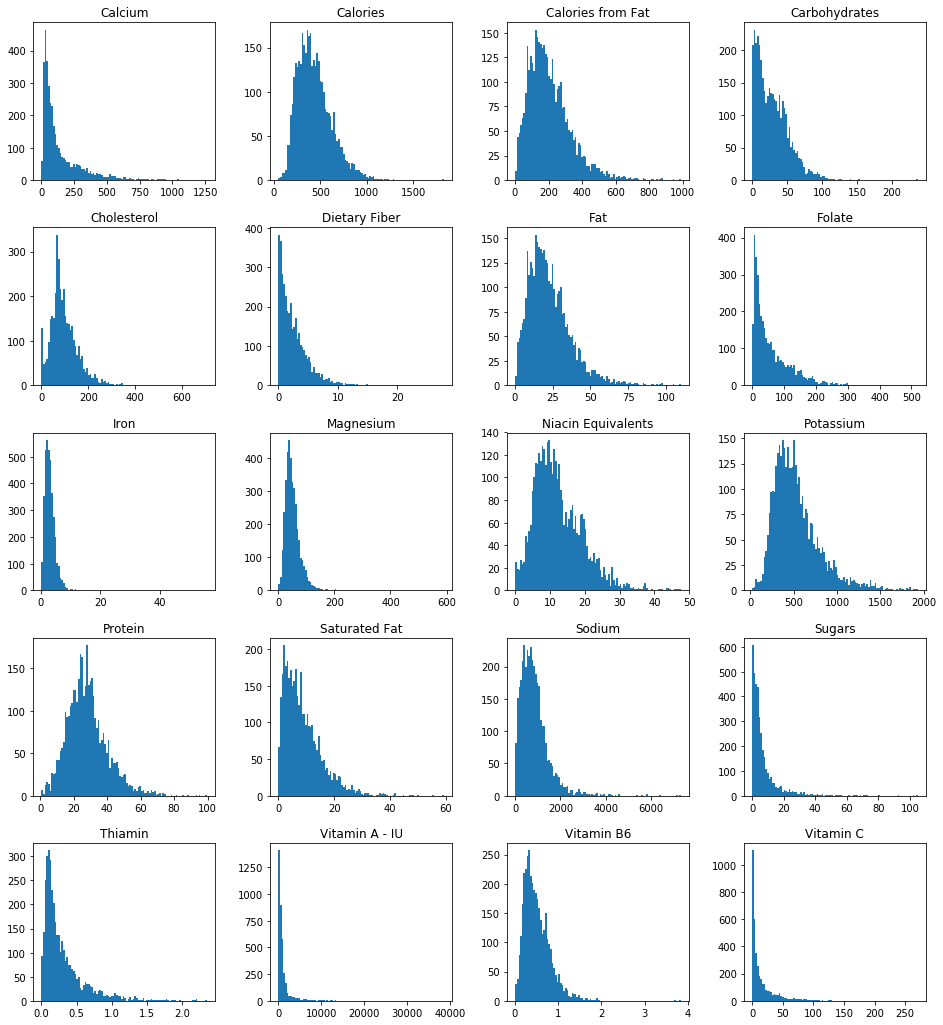

In [72]:
nutrition_db2.hist(bins= 100, grid= 'false', figsize = (16,18))

In [46]:
gramms_ingredients

id  ingredients_grams
0       6900          184.35112
1       7198         1238.50889
2       8493         1280.50000
3       8494         1671.56307
4       8495          817.26250
...      ...                ...
4056  258878          456.93333
4057  259870         3484.50000
4058  260193         1464.50000
4059  261124         1156.96946
4060  263813         1354.54835

[4061 rows x 2 columns]

In [47]:
df.sort_values(by='ingredients_grams')

id  ingredients_grams
1214   20881           21.22222
2493   79255           73.29343
2831  106030           79.13929
1788   34531           91.28767
410    12063          107.10890
...      ...                ...
140     8772         2364.46678
3650  228045         2364.60208
1926   44033         2365.12018
3042  151997         2366.98766
1569   25135         2373.58225

[3957 rows x 2 columns]

In [40]:
grams_wo_outliers = gramms_ingredients[gramms_ingredients['ingredients_grams'].between(500, 2500, inclusive=False)].copy()

In [ ]:
emp[emp["Salary"].between(60000, 61000)]

In [42]:
grams_wo_outliers.sort_values(by='ingredients_grams')

id  ingredients_grams
549    14511          500.78858
3359  214759          501.52500
2516   80827          502.37646
1045   18377          502.93333
2196   60704          503.60000
...      ...                ...
880    16900         2483.33344
3163  177078         2488.70014
1737   30834         2489.44500
3486  219163         2489.60542
468    12839         2491.11147

[3793 rows x 2 columns]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x126564c90>]],
      dtype=object)

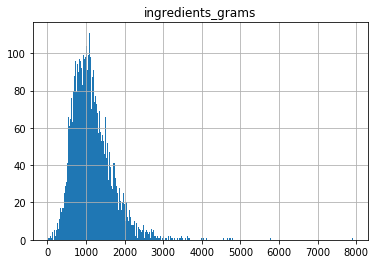

In [51]:
gramms_ingredients.hist(column='ingredients_grams', bins=300)


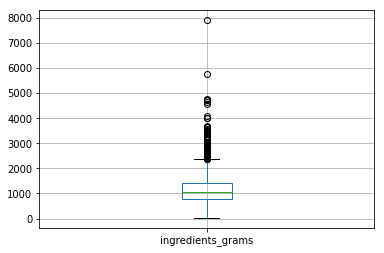

In [50]:
gramms_ingredients.boxplot(['ingredients_grams'])

In [25]:
# setze multiinde auf 'id' und 'ingredients_id'
ingredients = new_ingredients.set_index(['id', 'ingredients_id'])

In [ ]:
ingredients.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1218a5410>]],
      dtype=object)

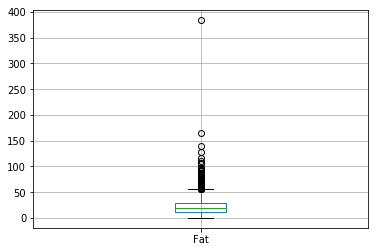

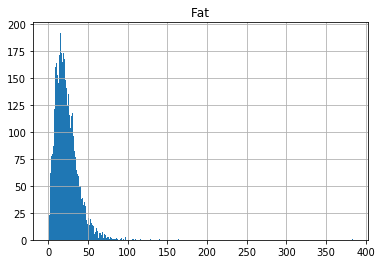

In [31]:
nutrition_db.boxplot(['Fat'])
nutrition_db.hist(column='Fat', bins=300)
